In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import gpplot
import matplotlib.pyplot as plt
import re
from scipy import stats

In [2]:
gpplot.set_aesthetics()

In [3]:
experimental_data = pd.read_csv('../data/raw/Supplementary Table 3 SynLet screening data.txt', sep = '\t')
sp_designs = pd.read_csv('../data/raw/sp_synlet_sgrna-designs.txt', sep = '\t')
sa_designs = pd.read_csv('../data/raw/sa_synlet_sgrna-designs.txt', sep = '\t')
ceres = pd.read_csv('../data/external/bigpapi_ceres.csv')

## pDNA filtering

In [4]:
pdna_data = experimental_data[['U6 Sequence;H1 Sequence', 'pDNA Reads']].drop_duplicates()

In [5]:
experimental_data.shape[0]/pdna_data.shape[0]

10.0

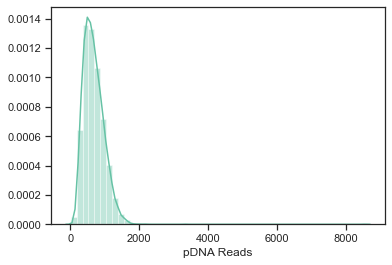

In [6]:
sns.distplot(pdna_data['pDNA Reads'])

It's odd to see pDNA reads have different lognorm values. For this reason we'll recalculate lognorms 

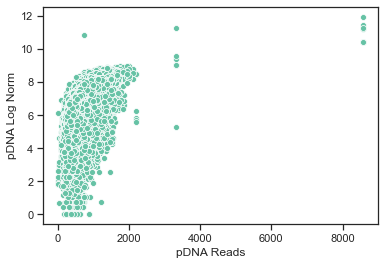

In [7]:
sns.scatterplot(data = experimental_data, x =  'pDNA Reads', y = 'pDNA Log Norm')

In [8]:
def lognormalize(v):
    lognorm = np.log2(v/v.sum()*1000000 + 1)
    return lognorm

pdna_data['pDNA_lognorm'] = lognormalize(pdna_data['pDNA Reads']) 
pdna_data['pDNA_zscore'] = (pdna_data['pDNA_lognorm'] - pdna_data['pDNA_lognorm'].mean())/pdna_data['pDNA_lognorm'].std()

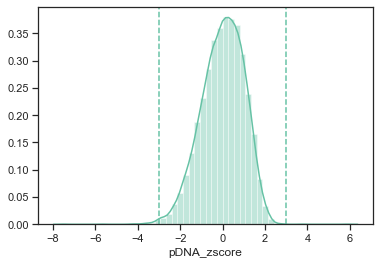

In [9]:
sns.distplot(pdna_data['pDNA_zscore'])
plt.axvline(x = -3, linestyle = 'dashed')
plt.axvline(x = 3, linestyle = 'dashed')

In [10]:
filtered_pdna = pdna_data.loc[pdna_data['pDNA_zscore'].abs() < 3, ['U6 Sequence;H1 Sequence', 'pDNA_lognorm']]

In [11]:
print('filtered ' + str(pdna_data.shape[0] - filtered_pdna.shape[0]) + ' guides due to low pDNA abundance')

filtered 32 guides due to low pDNA abundance


## Off target filtering

In [12]:
experimental_columns = ['U6 Sequence;H1 Sequence', 'U6 gene', 'H1 gene', 'Cell Line', 
                       'Rep A Reads', 'Rep B Reads', 'Rep C Reads', 'Time Point']
clean_read_data = (experimental_data[experimental_columns]
                   .melt(id_vars=list(set(experimental_columns) - {'Rep A Reads', 'Rep B Reads', 'Rep C Reads'}),
                         var_name='Rep', value_name='Reads'))
clean_read_data[['U6 Sequence', 'H1 Sequence']] = clean_read_data['U6 Sequence;H1 Sequence'].str.split(';', expand = True)
clean_read_data = clean_read_data[~clean_read_data['Reads'].isna()]

In [13]:
spyo_guides = clean_read_data[['U6 Sequence', 'U6 gene']].drop_duplicates()

In [14]:
sp_bound_designs = spyo_guides.merge(sp_designs, left_on=['U6 Sequence', 'U6 gene'], 
                                     right_on=['sgRNA Sequence', 'Target Gene Symbol'], how='left')

We recover all sp guides in the design file

In [15]:
(sp_bound_designs.groupby('U6 gene')
 .apply(lambda df: np.sum(df.Input.isna())/df.shape[0]))

U6 gene
6T             1.0
AKT1           0.0
AKT2           0.0
AKT3           0.0
BCL2           0.0
BCL2A1         0.0
BCL2L1         0.0
BCL2L10        0.0
BCL2L2         0.0
BRCA1          0.0
BRCA2          0.0
CD81           0.0
CHEK1          0.0
CHEK2          0.0
EEF2           0.0
HPRT intron    1.0
HSP90AA1       0.0
IMPDH1         0.0
MAP2K1         0.0
MAP2K2         0.0
MAPK1          0.0
MAPK3          0.0
MCL1           0.0
MTOR           0.0
PARP1          0.0
PARP2          0.0
UBB            0.0
UBC            0.0
WEE1           0.0
dtype: float64

In [16]:
bin1_cols = [x for x in sp_bound_designs.columns if re.search('Bin I ', x)]

Since only one guide has a perfect match in a Tier III column, we will not do off target filtering

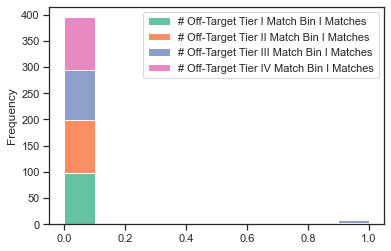

In [17]:
sp_bound_designs[bin1_cols].fillna(0).astype(int).plot.hist(stacked=True)

In [18]:
def rev_comp(guide):
    comp = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    rev_comp_guide = ''.join(comp[c] for c in guide[::-1])
    return rev_comp_guide

    
saur_guides = clean_read_data[['H1 Sequence', 'H1 gene']].drop_duplicates()
saur_guides['H1 Sequence'] = saur_guides['H1 Sequence'].apply(rev_comp)

In [19]:
sa_bound_designs = saur_guides.merge(sa_designs, left_on=['H1 Sequence', 'H1 gene'], 
                                     right_on=['sgRNA Sequence', 'Target Gene Symbol'], how='left')

In [20]:
(sa_bound_designs.groupby('H1 gene')
 .apply(lambda df: np.sum(df.Input.isna())/df.shape[0]))

H1 gene
6T             1.0
AKT1           0.0
AKT2           0.0
AKT3           0.0
BCL2           0.0
BCL2A1         0.0
BCL2L1         0.0
BCL2L10        0.0
BCL2L2         0.0
BRCA1          0.0
BRCA2          0.0
CD81           0.0
CHEK1          0.0
CHEK2          0.0
EEF2           0.0
HPRT intron    1.0
HSP90AA1       0.0
IMPDH1         0.0
MAP2K1         0.0
MAP2K2         0.0
MAPK1          0.0
MAPK3          0.0
MCL1           0.0
MTOR           0.0
PARP1          0.0
PARP2          0.0
UBB            0.0
UBC            0.0
WEE1           0.0
dtype: float64

Since only one guide has a perfect match in a Tier III column, we will not do off target filtering

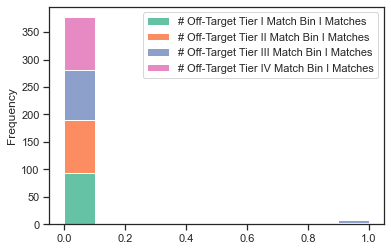

In [21]:
sa_bound_designs[bin1_cols].fillna(0).astype(int).plot.hist(stacked=True)

## Calculating LFCs

In [22]:
clean_read_data['lognorm'] = (clean_read_data.groupby(['Time Point', 'Cell Line', 'Rep'])
                              .Reads
                              .transform(lambda x: lognormalize(x)))
lfcs = clean_read_data.merge(filtered_pdna, how = 'inner', on = 'U6 Sequence;H1 Sequence')
lfcs['lfc'] = lfcs['lognorm'] - lfcs['pDNA_lognorm']
lfcs['condition'] = lfcs['Time Point'] + '_' + lfcs['Cell Line'] + '_' + lfcs['Rep']
lfcs['condition'] = lfcs['condition'].str.strip('Reads')

In [23]:
pivoted_lfcs = lfcs.pivot(index='U6 Sequence;H1 Sequence', columns = 'condition', values = 'lfc')
cor_mat = pivoted_lfcs.corr()

The correlations between thte different conditions look really good, so we'll combine lfcs for day 21 conditions

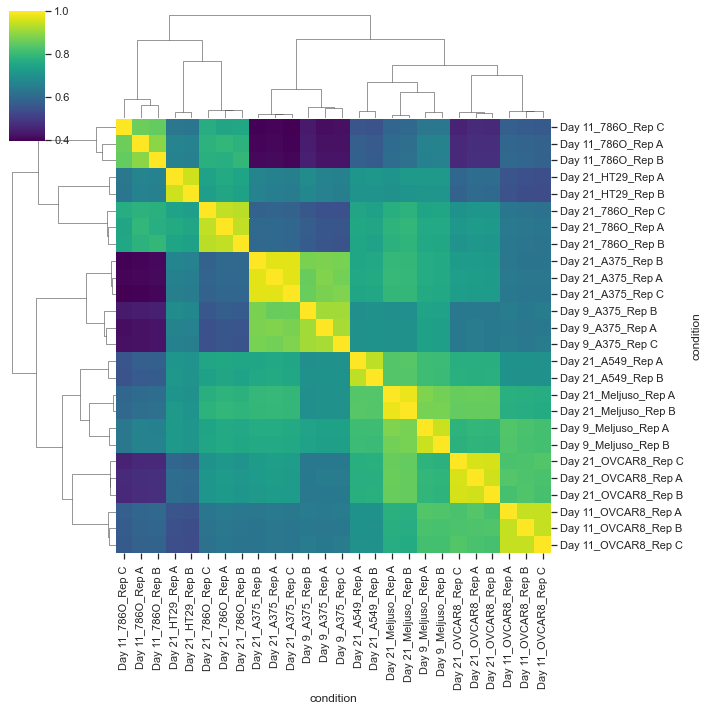

In [24]:
sns.clustermap(cor_mat, cmap = gpplot.style.sequential_cmap())

In [25]:
lfcs['day_cell'] = lfcs['Time Point'] + '_' + lfcs['Cell Line']
avg_lfcs = (lfcs[lfcs['Time Point'] == 'Day 21']
            .groupby(['U6 Sequence', 'H1 Sequence', 'H1 gene', 'U6 gene', 'day_cell'])
            .agg({'lfc': 'mean'})
            .reset_index())

## Comparing gene-level LFCs with CERES

In [26]:
long_ceres = (ceres
              .drop(['depmap_id', 'lineage_1', 'lineage_2', 'lineage_3', 'lineage_4'], axis=1)
              .melt(id_vars = 'cell_line_display_name', var_name='Gene', value_name='CERES'))

In [27]:
avg_lfc_cell = avg_lfcs
avg_lfc_cell[['day', 'cell']] = avg_lfc_cell['day_cell'].str.split('_', expand=True)
avg_lfc_cell['cell'] = avg_lfc_cell['cell'].str.replace('Meljuso', 'MELJUSO')

In [28]:
H1_gene_lfcs = (avg_lfc_cell[avg_lfc_cell['U6 gene'] == '6T']
                .groupby(['cell', 'H1 gene'])
                .agg({'lfc': 'mean'})
                .reset_index()
                .merge(long_ceres, how = 'inner', left_on = ['H1 gene', 'cell'], 
                       right_on = ['Gene', 'cell_line_display_name']))
H1_gene_cors = (H1_gene_lfcs
                .groupby(['cell'])
                .apply(lambda df: stats.pearsonr(df['lfc'], df['CERES'])[0])
                .reset_index(name = 'pearson'))
H1_gene_cors

,cell,pearson
0,786O,0.796967
1,A375,0.711529
2,A549,0.803334
3,HT29,0.637011
4,MELJUSO,0.865681
5,OVCAR8,0.865413


In [29]:
U6_gene_lfcs = (avg_lfc_cell[avg_lfc_cell['H1 gene'] == '6T']
                .groupby(['cell', 'U6 gene'])
                .agg({'lfc': 'mean'})
                .reset_index()
                .merge(long_ceres, how = 'inner', left_on = ['U6 gene', 'cell'], 
                       right_on = ['Gene', 'cell_line_display_name']))
U6_gene_cors = (U6_gene_lfcs
                .groupby(['cell'])
                .apply(lambda df: stats.pearsonr(df['lfc'], df['CERES'])[0])
                .reset_index(name = 'pearson'))
U6_gene_cors

,cell,pearson
0,786O,0.854490
1,A375,0.785370
2,A549,0.823096
3,HT29,0.864794
4,MELJUSO,0.862071
5,OVCAR8,0.869913


In [30]:
joined_ceres_cors = H1_gene_cors.merge(U6_gene_cors, how='inner', on='cell', suffixes=['_H1', '_U6'])

Text(0.5, 1.0, 'Correlation with DepMap')

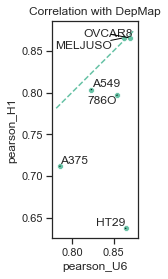

In [31]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
ax = sns.scatterplot(data=joined_ceres_cors, x='pearson_U6', y='pearson_H1')
plt.gca().set_aspect('equal')
gpplot.label_points(ax, joined_ceres_cors, 'pearson_U6', 'pearson_H1', joined_ceres_cors.cell, 
                    'cell')
abline(1, 0)
plt.title('Correlation with DepMap')

## Data output

In [36]:
out_data = (avg_lfcs.pivot_table(index=['U6 Sequence', 'H1 Sequence', 'U6 gene', 'H1 gene'],
                                 columns='day_cell', values='lfc')
            .reset_index())
out_data.to_csv('../data/processed/bigpapi_lfcs.csv', index=False)